In [36]:

import numpy as np
from torch import nn
from PIL import Image, ImageOps
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.image as mpimg

import os
from keras.applications.vgg16 import VGG16
import kagglehub



In [37]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

idx1_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(idx1_dataset, batch_size=64, shuffle=True)

idx1_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
loaderTest = DataLoader(idx1_test, batch_size=64, shuffle=False)

for X,y in loader:
    print(X.shape)
    print(y.shape, y.dtype)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64]) torch.int64


In [38]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

print(f"device: {device}")

device: mps


In [39]:
class NueralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(nn.Linear(28*28, 512), 
                                     nn.ReLU(), 
                                     nn.Linear(512, 512),
                                     nn.ReLU(),
                                     nn.Linear(512,10))
    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [40]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



    

In [41]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### **1. Base Configuration**

In [42]:

model = NueralNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

epochs = 5 
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(loader, model, loss_fn, optimizer)
    test(loaderTest, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.315034  [   64/60000]
loss: 2.286483  [ 6464/60000]
loss: 2.239048  [12864/60000]
loss: 2.193045  [19264/60000]
loss: 2.144700  [25664/60000]
loss: 2.087162  [32064/60000]
loss: 2.023291  [38464/60000]
loss: 1.974257  [44864/60000]
loss: 1.857503  [51264/60000]
loss: 1.887936  [57664/60000]
Test Error: 
 Accuracy: 71.9%, Avg loss: 1.777145 

Epoch 2
-------------------------------
loss: 1.888212  [   64/60000]
loss: 1.689619  [ 6464/60000]
loss: 1.598794  [12864/60000]
loss: 1.508066  [19264/60000]
loss: 1.500436  [25664/60000]
loss: 1.262134  [32064/60000]
loss: 1.219414  [38464/60000]
loss: 1.051600  [44864/60000]
loss: 0.970804  [51264/60000]
loss: 0.958521  [57664/60000]
Test Error: 
 Accuracy: 80.7%, Avg loss: 0.966234 

Epoch 3
-------------------------------
loss: 1.036318  [   64/60000]
loss: 0.971765  [ 6464/60000]
loss: 0.980676  [12864/60000]
loss: 0.833992  [19264/60000]
loss: 0.856325  [25664/60000]
loss: 0.733275  [32064/600

**Explanation:**  
- `NueralNetwork` outputs raw logits, which align correctly with `nn.CrossEntropyLoss`.
- The use of `SGD` with a learning rate of `1e-3` leads to stable training and good accuracy (~88.9%).
- This setup is mathematically correct and performs well.

# Model Configurations and Results

### **2. Changed Optimizer Type**

In [43]:
model = Net().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.Adadelta(model.parameters(), lr = 1e-3)

epochs = 5 
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(loader, model, loss_fn, optimizer)
    test(loaderTest, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.319017  [   64/60000]
loss: 2.240031  [ 6464/60000]
loss: 2.219429  [12864/60000]
loss: 2.202428  [19264/60000]
loss: 2.160276  [25664/60000]
loss: 2.112474  [32064/60000]
loss: 2.052041  [38464/60000]
loss: 1.947716  [44864/60000]
loss: 1.901538  [51264/60000]
loss: 1.777352  [57664/60000]
Test Error: 
 Accuracy: 76.8%, Avg loss: 1.739431 

Epoch 2
-------------------------------
loss: 1.791808  [   64/60000]
loss: 1.715565  [ 6464/60000]
loss: 1.701730  [12864/60000]
loss: 1.471373  [19264/60000]
loss: 1.415198  [25664/60000]
loss: 1.389085  [32064/60000]
loss: 1.271994  [38464/60000]
loss: 1.175642  [44864/60000]
loss: 1.142135  [51264/60000]
loss: 1.280625  [57664/60000]
Test Error: 
 Accuracy: 82.9%, Avg loss: 0.911690 

Epoch 3
-------------------------------
loss: 1.015160  [   64/60000]
loss: 1.057798  [ 6464/60000]
loss: 0.920756  [12864/60000]
loss: 1.131007  [19264/60000]
loss: 0.929866  [25664/60000]
loss: 1.012021  [32064/600

**Explanation:**  
- `Net()` outputs log probabilities using `F.log_softmax`.
- `nn.CrossEntropyLoss` expects raw logits, so this configuration applies `log_softmax` twice: `log_softmax(log(softmax(...)))`.  
- This mismatch leads to suboptimal gradient computation but still achieves decent accuracy (~89.5%) due to the robustness of neural networks. However, it is not mathematically sound and may not generalize well.


### **3. Changed Loss Function (`loss_fn`)**

In [44]:
model = Net().to(device)

loss_fn = nn.NLLLoss()
optimizer= torch.optim.SGD(model.parameters(), lr = 1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(loader, model, loss_fn, optimizer)
    test(loaderTest, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.305311  [   64/60000]
loss: 2.214709  [ 6464/60000]
loss: 1.968969  [12864/60000]
loss: 1.829661  [19264/60000]
loss: 1.414545  [25664/60000]
loss: 1.171876  [32064/60000]
loss: 1.018690  [38464/60000]
loss: 1.005191  [44864/60000]
loss: 0.940643  [51264/60000]
loss: 0.641867  [57664/60000]
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.509963 

Epoch 2
-------------------------------
loss: 0.678478  [   64/60000]
loss: 0.685668  [ 6464/60000]
loss: 0.541660  [12864/60000]
loss: 0.357854  [19264/60000]
loss: 0.521981  [25664/60000]
loss: 0.525979  [32064/60000]
loss: 0.607698  [38464/60000]
loss: 0.583878  [44864/60000]
loss: 0.526609  [51264/60000]
loss: 0.617558  [57664/60000]
Test Error: 
 Accuracy: 90.9%, Avg loss: 0.336854 

Epoch 3
-------------------------------
loss: 0.486879  [   64/60000]
loss: 0.445529  [ 6464/60000]
loss: 0.268462  [12864/60000]
loss: 0.704240  [19264/60000]
loss: 0.494975  [25664/60000]
loss: 0.429579  [32064/600

**Explanation:**  
- Using `nn.NLLLoss` matches `Net()`'s output of log probabilities (`F.log_softmax`), ensuring proper gradient computation.
- This alignment improves training dynamics, leading to better accuracy (~93.4%).
- Correct loss function selection is critical for effective training.


### **4. Changed Loss Function and Optimizer Learning Rate to 1**

In [45]:
# Changed loss_f and optimizer to 1

model = Net().to(device)

loss_fn = nn.NLLLoss()
optimizer= torch.optim.SGD(model.parameters(), lr = 1)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(loader, model, loss_fn, optimizer) 
    test(loaderTest, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.300282  [   64/60000]
loss:     nan  [ 6464/60000]
loss:     nan  [12864/60000]
loss:     nan  [19264/60000]
loss:     nan  [25664/60000]
loss:     nan  [32064/60000]
loss:     nan  [38464/60000]
loss:     nan  [44864/60000]
loss:     nan  [51264/60000]
loss:     nan  [57664/60000]
Test Error: 
 Accuracy: 9.8%, Avg loss:      nan 

Epoch 2
-------------------------------
loss:     nan  [   64/60000]
loss:     nan  [ 6464/60000]
loss:     nan  [12864/60000]
loss:     nan  [19264/60000]
loss:     nan  [25664/60000]
loss:     nan  [32064/60000]
loss:     nan  [38464/60000]
loss:     nan  [44864/60000]
loss:     nan  [51264/60000]
loss:     nan  [57664/60000]
Test Error: 
 Accuracy: 9.8%, Avg loss:      nan 

Epoch 3
-------------------------------
loss:     nan  [   64/60000]
loss:     nan  [ 6464/60000]
loss:     nan  [12864/60000]
loss:     nan  [19264/60000]
loss:     nan  [25664/60000]
loss:     nan  [32064/60000]
loss:     nan  [38464/6

## Why This is Wrong:
1. **Loss Function (`nn.NLLLoss`) is Matched Correctly:**
   - The `Net()` model outputs log probabilities using `F.log_softmax`, which is the correct input format for `nn.NLLLoss`.
   - Therefore, the loss function is **not the source of the issue**.

2. **Learning Rate (`lr=1`) is Too High:**
   - A learning rate of `1` for `SGD` causes gradient updates to overshoot the optimal weights, preventing effective convergence.
   - The stagnant accuracy (~11%) and consistently high loss values across epochs indicate that the model is not learning.

3. **Lack of Convergence:**
   - The combination of a high learning rate and `SGD` results in excessively large weight updates, destabilizing the training process.
   - This prevents the model from optimizing properly, leading to poor performance.

4. **High Loss Values Persist:**
   - With a high learning rate, gradients likely explode or oscillate, making it difficult for the model to stabilize and reduce the loss.
   - The model essentially guesses randomly, reflected by the accuracy (~11%, similar to random guessing for a 10-class problem).


### **5. Changed Optimizer Type and Loss Function**

In [46]:

model = Net().to(device)


loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr = 1e-3)

epochs = 5 
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(loader, model, loss_fn, optimizer)
    test(loaderTest, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.327518  [   64/60000]
loss: 2.268046  [ 6464/60000]
loss: 2.247958  [12864/60000]
loss: 2.208548  [19264/60000]
loss: 2.165229  [25664/60000]
loss: 2.094087  [32064/60000]
loss: 2.024014  [38464/60000]
loss: 1.990599  [44864/60000]
loss: 1.824877  [51264/60000]
loss: 1.749631  [57664/60000]
Test Error: 
 Accuracy: 76.6%, Avg loss: 1.619667 

Epoch 2
-------------------------------
loss: 1.629912  [   64/60000]
loss: 1.588315  [ 6464/60000]
loss: 1.454926  [12864/60000]
loss: 1.373632  [19264/60000]
loss: 1.249967  [25664/60000]
loss: 1.194409  [32064/60000]
loss: 1.212227  [38464/60000]
loss: 1.073718  [44864/60000]
loss: 1.160255  [51264/60000]
loss: 1.152254  [57664/60000]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.792541 

Epoch 3
-------------------------------
loss: 0.855385  [   64/60000]
loss: 0.902549  [ 6464/60000]
loss: 0.860673  [12864/60000]
loss: 0.833669  [19264/60000]
loss: 0.943965  [25664/60000]
loss: 0.738686  [32064/600

## Why This Achieved 90.4% Accuracy

1. **Correct Loss Function (`nn.NLLLoss`):**
   - The `Net()` model outputs log probabilities using `F.log_softmax`, which align perfectly with `nn.NLLLoss`.
   - This ensures proper gradient computation and stable training, enabling the model to optimize effectively.

2. **Adaptive Optimizer (`Adadelta`):**
   - `Adadelta` dynamically adjusts the learning rate during training, making it robust to small initial learning rates like `1e-3`.
   - Its adaptability ensures stable convergence even with challenging hyperparameter settings.

3. **Balanced Training Dynamics:**
   - The combination of a matched loss function and a robust optimizer allowed the model to learn efficiently.
   - Training for five epochs provided sufficient time for the model to achieve **90.4% accuracy** on the MNIST test dataset.

4. **Conclusion:**
   - This setup highlights the importance of aligning the loss function with the model's output and selecting an appropriate optimizer for effective learning.


### **6. Changed Optimizer to 1 and Loss Function**

In [47]:
model = Net().to(device)

    
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr = 1)

epochs = 5 
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(loader, model, loss_fn, optimizer)
    test(loaderTest, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295103  [   64/60000]
loss: 0.300671  [ 6464/60000]
loss: 0.345443  [12864/60000]
loss: 0.215815  [19264/60000]
loss: 0.084297  [25664/60000]
loss: 0.364286  [32064/60000]
loss: 0.036912  [38464/60000]
loss: 0.058033  [44864/60000]
loss: 0.162910  [51264/60000]
loss: 0.120553  [57664/60000]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.045810 

Epoch 2
-------------------------------
loss: 0.010138  [   64/60000]
loss: 0.055568  [ 6464/60000]
loss: 0.083560  [12864/60000]
loss: 0.097783  [19264/60000]
loss: 0.146802  [25664/60000]
loss: 0.230263  [32064/60000]
loss: 0.065327  [38464/60000]
loss: 0.103895  [44864/60000]
loss: 0.143842  [51264/60000]
loss: 0.082730  [57664/60000]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.036745 

Epoch 3
-------------------------------
loss: 0.017039  [   64/60000]
loss: 0.011097  [ 6464/60000]
loss: 0.060552  [12864/60000]
loss: 0.016573  [19264/60000]
loss: 0.017958  [25664/60000]
loss: 0.028073  [32064/600

**Explanation:**  
- Proper alignment between `nn.NLLLoss` and `Net()`'s log probability output ensures correct gradient computation.
- Using `SGD` with a high learning rate of `1` accelerates convergence.
- This setup is mathematically sound and performs well, achieving consistent high accuracy (~93.4%).

In [48]:
# Changed optimizer to 1,  and loss_fn

model = Net().to(device)

loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1)

epochs = 5 
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(loader, model, loss_fn, optimizer)
    test(loaderTest, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.291305  [   64/60000]
loss: 1.413808  [ 6464/60000]
loss: 1.000015  [12864/60000]
loss: 0.667317  [19264/60000]
loss: 0.648090  [25664/60000]
loss: 0.371900  [32064/60000]
loss: 0.803730  [38464/60000]
loss: 0.762061  [44864/60000]
loss: 2.310365  [51264/60000]
loss: 2.312693  [57664/60000]
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.303194 

Epoch 2
-------------------------------
loss: 2.291839  [   64/60000]
loss: 2.311959  [ 6464/60000]
loss: 2.273559  [12864/60000]
loss: 2.294441  [19264/60000]
loss: 2.283589  [25664/60000]
loss: 2.304290  [32064/60000]
loss: 2.318990  [38464/60000]
loss: 2.281663  [44864/60000]
loss: 2.314061  [51264/60000]
loss: 2.293481  [57664/60000]
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.303098 

Epoch 3
-------------------------------
loss: 2.303495  [   64/60000]
loss: 2.311114  [ 6464/60000]
loss: 2.300283  [12864/60000]
loss: 2.299111  [19264/60000]
loss: 2.321725  [25664/60000]
loss: 2.300591  [32064/600

# Why This Achieved Terrible Accuracy (11.3%)

1. **Learning Rate Too High (`lr=1`):**  
   - Using `SGD` with a high learning rate (`lr=1`) caused the model's weight updates to overshoot the optimal values. This prevented convergence and led to consistently poor accuracy (~11.3%, akin to random guessing).

2. **Correct Loss Function (`nn.NLLLoss`):**  
   - The `Net()` model outputs log probabilities, and `nn.NLLLoss` is the correct choice for this output format. However, the high learning rate undermined the training process, rendering the correct loss function ineffective.

3. **Training Instability:**  
   - The combination of `SGD` and an excessive learning rate led to large gradient updates, destabilizing training and preventing the model from reducing loss or improving accuracy.

### Key Fix:  
Reducing the learning rate (e.g., `lr=0.01` or `lr=0.1`) would allow the model to converge effectively and achieve much better performance.


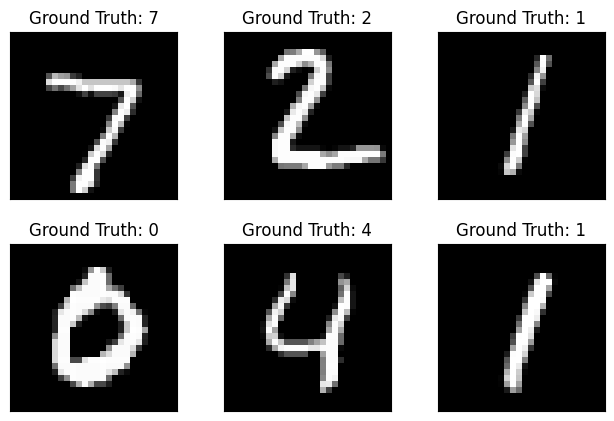

In [49]:
examples = enumerate(loaderTest)
batch_idx, (example_data, example_targets) = next(examples)

print(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [21]:
# class ConvolutionalNueralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.flatten = nn.Flatten()
#         self.conv1 = nn.Conv2d(in_channels = 1, out_channels=16, kernel_size=3, padding = 1, stride = 1)
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding = 1, stride = 1)
#         self.conv2_drop = nn.Dropout2d()
#         self.layer1 = nn.Linear(32*14*14, 128)
#         self.layer2 = nn.Linear(128, 10)
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool2d(2)

#     def forward(self, x):
#         x = nn.ReLU(nn.MaxPool2d(self.conv1, 2))
#         x = nn.ReLU(nn.MaxPool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = nn.ReLU(self.layer1(x))
#         x = nn.Dropout(x, training = self.training)
#         x = self.layer2(x)


#         return nn.LogSoftmax(x)

#         # # x = self.conv1(x)
#         # # x = self.relu(x)
#         # # x = self.conv2(x)
#         # # x = self.relu(x)
#         # # x = nn.MaxPool2d(x, 2)
#         # # x = self.flatten(x)
#         # # x = self.layer1(x)
#         # # x = self.relu(x)
#         # # x = self.layer2(x)
#         # return x